In [117]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


In [118]:

# Define the file paths
file_paths = [
    'data/POP_FECHADAS_N5/BD_N5 111-117_ACTUALIZADO.csv',
    'data/POP_FECHADAS_N5/BD_N5 118-164_ACTUALIZADO.csv',
    'data/POP_FECHADAS_N5/BD_N5 165-193_ACTUALIZADO.csv',
    'data/POP_FECHADAS_N5/BD_N5 171-150_ACTUALIZADO.csv'
]

# Read the CSV files and store them in a list
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate the dataframes vertically
combined_df = pd.concat(dfs, ignore_index=True)

# Format the 'N4' column as a string with 4 characters, filled with 0
combined_df['N4'] = combined_df['N4'].astype(str).str.zfill(4)
combined_df['Freguesia'] = combined_df['N4'].astype(str)+combined_df['N5'].astype(str).str.zfill(2)

/tmp/ipykernel_13752/3315337866.py:12: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [138]:
len(combined_df['Freguesia'].unique())

2882

In [133]:
filtered_combined_df = combined_df.copy()
desired_years = [2020, 2030, 2040]

# 1. Identify the unique columns to detect duplicates
unique_columns = ['N4', 'N5', 'Ano', 'Cen', 'GE']

# Drop duplicates based on the unique columns, keeping the first occurrence
filtered_combined_df = filtered_combined_df.drop_duplicates(subset=unique_columns, keep='first')
filtered_combined_df = filtered_combined_df[filtered_combined_df.Cen==1]


# 2. Aggregate the data at the N5 level for each year in the desired_years list
aggregated_dfs = []
for year in desired_years:
    # Filter by the desired year
    year_filtered_combined_df = filtered_combined_df[filtered_combined_df['Ano'] == year]
    
    # Group by N5 and sum only the required columns
    year_aggregated_df = year_filtered_combined_df.groupby('Freguesia')[['PopAbertH', 'PopAbertM', 'PopFechH', 'PopFechM']].sum()
    
    # Calculate the total columns
    year_aggregated_df['Total_Aberta_{}'.format(year)] = year_aggregated_df.PopAbertH + year_aggregated_df.PopAbertM
    year_aggregated_df['Total_Fechada_{}'.format(year)] = year_aggregated_df.PopFechH + year_aggregated_df.PopFechM
    
    # Rename the columns to include the year
    year_aggregated_df.rename(columns={
        'PopAbertH': 'PopAbertH_{}'.format(year),
        'PopAbertM': 'PopAbertM_{}'.format(year),
        'PopFechH': 'PopFechH_{}'.format(year),
        'PopFechM': 'PopFechM_{}'.format(year)
    }, inplace=True)
    
    # Append the aggregated DataFrame to the list
    aggregated_dfs.append(year_aggregated_df)

N5_data = pd.concat(aggregated_dfs, axis=1)

In [134]:
N5_data.shape

(2882, 18)

In [121]:
# calculate the ratios based on the updated data
base_year = desired_years[0]
for year in desired_years[1:]:
    ratio_column = 'ratio_{}'.format(year)
    N5_data[ratio_column] = ((N5_data['Total_Aberta_{}'.format(year)] / N5_data['Total_Aberta_{}'.format(base_year)]) - 1) * 100
    N5_data[ratio_column] = N5_data[ratio_column].round(2)

In [122]:
# Load Shapefiles and merge with the data

portugal_polygons = gpd.read_file('./data/pt_polygons/BGRI11_CONT.shp')


In [123]:
portugal_polygons['Freguesia'] = portugal_polygons['DTMN11'].astype(str).str.zfill(4) + portugal_polygons['FR11'].astype(str).str.zfill(2)

In [124]:
portugal_freg = portugal_polygons.dissolve(by='Freguesia')

In [125]:
 # Get the Parishes names with correct encoding
freg_2011 = pd.read_csv('./data/Nome_freg_2011.csv')
freg_2011['Dicofreg_2011'] = freg_2011['Dicofreg_2011'].astype(str).str.zfill(6)
portugal_freg = portugal_freg.merge(freg_2011, left_on='Freguesia', right_on='Dicofreg_2011', how='left')

In [126]:
# Create a GeoDataFrame with the desired columns
portugal_freg_polygons = portugal_freg[['Dicofreg_2011', 'geometry', "Nomefreg_2011"]]
portugal_freg_polygons.index = portugal_freg_polygons['Dicofreg_2011']
portugal_freg_polygons.drop(columns=['Dicofreg_2011'], inplace=True)

# Merge the GeoDataFrame with the demographic data
portugal_freg_polygons = portugal_freg_polygons.merge(N5_data, left_index=True, right_index=True, how='left')


/tmp/ipykernel_13752/1640509068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portugal_freg_polygons.drop(columns=['Dicofreg_2011'], inplace=True)


In [127]:
portugal_freg_polygons.shape

(4050, 22)

In [132]:
N5_data.shape

(2882, 20)

<Axes: >

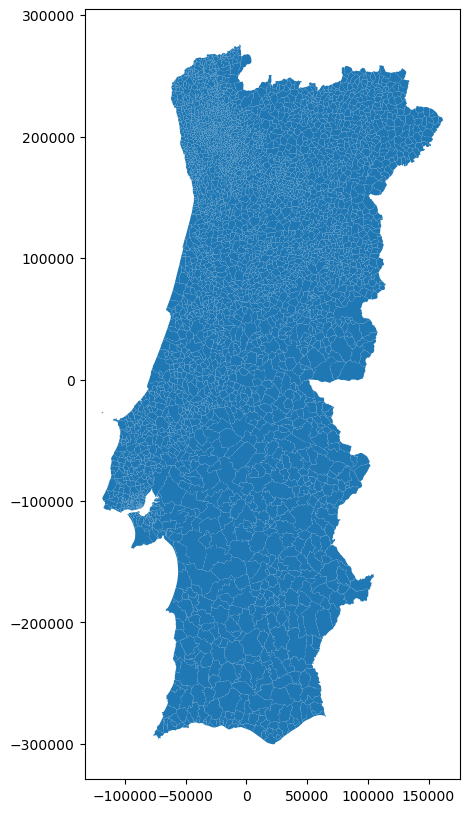

In [128]:
portugal_freg_polygons.plot(figsize=(15,10))

<Axes: >

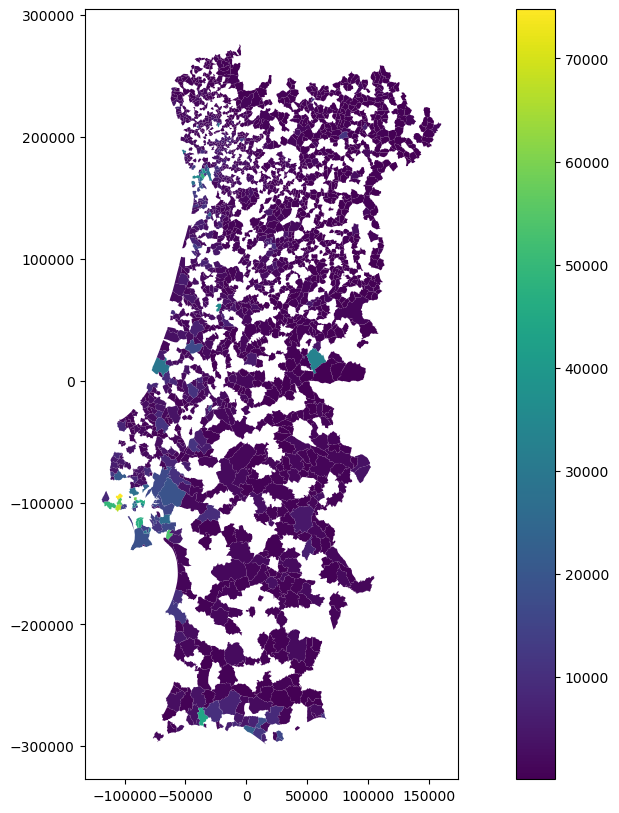

In [129]:
portugal_freg_polygons.plot(column='Total_Aberta_2040', legend=True, figsize=(15, 10))

In [136]:
N5_data.shape

(2882, 18)

In [130]:
portugal_freg_polygons[portugal_freg_polygons['Total_Aberta_2040'].isnull()]

,geometry,Nomefreg_2011,PopAbertH_2020,PopAbertM_2020,PopFechH_2020,PopFechM_2020,Total_Aberta_2020,Total_Fechada_2020,PopAbertH_2030,PopAbertM_2030,...,Total_Aberta_2030,Total_Fechada_2030,PopAbertH_2040,PopAbertM_2040,PopFechH_2040,PopFechM_2040,Total_Aberta_2040,Total_Fechada_2040,ratio_2030,ratio_2040
Dicofreg_2011,,,,,,,,,,,,,,,,,,,,,
010101,"POLYGON ((-12188.840 96371.828, -12124.291 963...",Agadão,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
010102,"POLYGON ((-27403.707 92865.479, -27907.449 929...",Aguada de Baixo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
010104,"POLYGON ((-26746.237 100365.139, -26798.507 10...",Águeda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
010105,"POLYGON ((-27609.049 94736.482, -27622.349 947...",Barrô,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
010106,"POLYGON ((-19937.984 94795.252, -19955.934 947...",Belazaima do Chão,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182404,"POLYGON ((-554.005 107817.119, -612.785 107824...",Carvalhal de Vermilhas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182405,"POLYGON ((5367.674 114389.700, 5164.266 114418...",Fataunços,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182406,"POLYGON ((7471.230 117264.937, 7352.478 117274...",Figueiredo das Donas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
N5_data.loc['182415']

PopAbertH_2020        296.00
PopAbertM_2020        325.00
PopFechH_2020         296.00
PopFechM_2020         325.00
Total_Aberta_2020     621.00
Total_Fechada_2020    621.00
PopAbertH_2030        280.00
PopAbertM_2030        312.00
PopFechH_2030         280.00
PopFechM_2030         312.00
Total_Aberta_2030     592.00
Total_Fechada_2030    592.00
PopAbertH_2040        264.00
PopAbertM_2040        291.00
PopFechH_2040         264.00
PopFechM_2040         291.00
Total_Aberta_2040     555.00
Total_Fechada_2040    555.00
ratio_2030             -4.67
ratio_2040            -10.63
Name: 182415, dtype: float64